In [1]:
import os
import time
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm



import opensmile


from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
import torch.nn.functional as F

from tensorflow.keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import SGD




In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [2]:
def one_hot_encode(y):
    enc = OneHotEncoder(sparse_output=False)  
    return enc.fit_transform(y.reshape(-1, 1)) 


def normalization(X, mean, std):
    return (X-mean)/std

In [3]:
speech_unprocessed_path = r'data/Audio_Speech_Actors_01-24/*/*.wav'
song_unprocessed_path = r'data/Audio_Song_Actors_01-24/*/*.wav'

speech_dataset_path = "configs/data/speech_dataset.npy"
song_dataset_path = "configs/data/song_dataset.npy"

In [4]:
def process_dataset(data_path, save_path):

    files = glob(data_path)

    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.eGeMAPSv02,
        feature_level=opensmile.FeatureLevel.Functionals,
    )
    extracted_features = smile.process_files(files)

    x_ = extracted_features.values
    y_ = np.array([int(os.path.basename(path).split('-')[2]) for path in files])

    y_reshaped = y_[:, np.newaxis] 
    speech_dataset = np.concatenate((x_, y_reshaped), axis=1)

    np.save(save_path, speech_dataset)
    return np.load(save_path)

process_dataset(speech_unprocessed_path, speech_dataset_path)
process_dataset(song_unprocessed_path, song_dataset_path)



array([[ 3.20263786e+01,  4.23245728e-02,  3.11146488e+01, ...,
         4.65268731e-01, -3.80827827e+01,  1.00000000e+00],
       [ 3.22532959e+01,  3.75403874e-02,  3.12140598e+01, ...,
         4.48131889e-01, -3.62435303e+01,  1.00000000e+00],
       [ 3.25768166e+01,  1.33287504e-01,  3.10158653e+01, ...,
         4.51725602e-01, -3.78288574e+01,  1.00000000e+00],
       ...,
       [ 4.44739647e+01,  3.61195505e-02,  4.34327240e+01, ...,
         4.86908585e-01, -3.15463219e+01,  6.00000000e+00],
       [ 4.47922134e+01,  5.01109287e-02,  4.32589912e+01, ...,
         4.31302935e-01, -3.15310917e+01,  6.00000000e+00],
       [ 4.41322784e+01,  7.11850077e-02,  4.35137901e+01, ...,
         4.26455140e-01, -2.93001766e+01,  6.00000000e+00]])

In [5]:
def get_dataset(path):
    dataset = np.load(path)
    x = dataset[:, :-1]
    y = dataset[:,-1]
    return x, y



In [6]:
x_speech, y_speech = get_dataset(speech_dataset_path)
x_song, y_song = get_dataset(song_dataset_path)

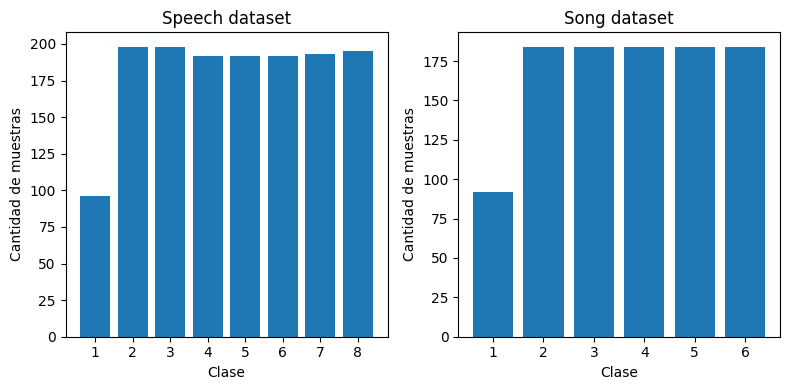

In [7]:
classes_speech, classes_count_speech = np.unique(y_speech, return_counts=True)
classes_song, classes_count_song = np.unique(y_song, return_counts=True)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) 

axs[0].bar(classes_speech, classes_count_speech)
axs[0].set_title('Speech dataset')
axs[0].set_xlabel('Clase')
axs[0].set_ylabel('Cantidad de muestras')
axs[0].set_xticks(classes_speech) 

axs[1].bar(classes_song, classes_count_song)
axs[1].set_title('Song dataset')
axs[1].set_xlabel('Clase')
axs[1].set_ylabel('Cantidad de muestras')
axs[1].set_xticks(classes_song)

plt.tight_layout()
plt.show()

#NOTE: There is no strong intensity for the 'neutral' emotion.

In [27]:
print(np.unique(y_speech))
print(np.unique(y_song))

y_speech = y_speech.astype(int)
y_song = y_song.astype(int)

[1. 2. 3. 4. 5. 6. 7. 8.]
[1. 2. 3. 4. 5. 6.]


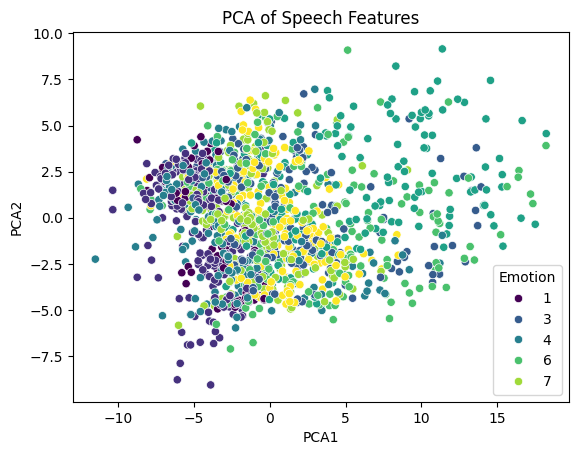

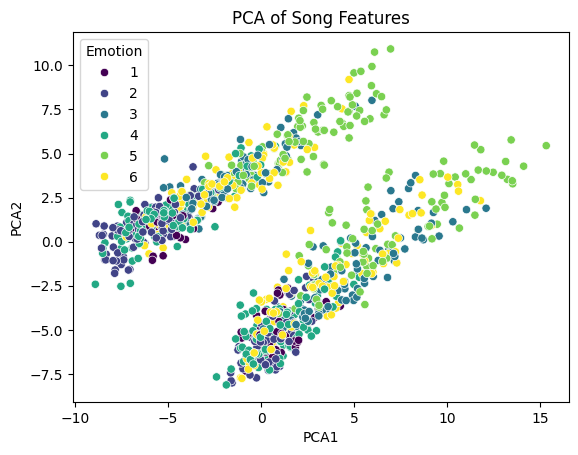

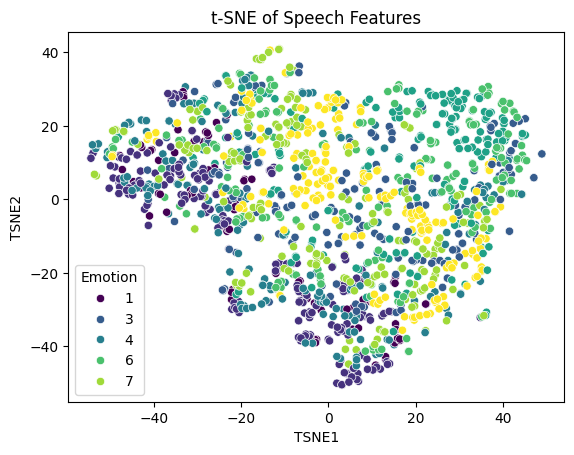

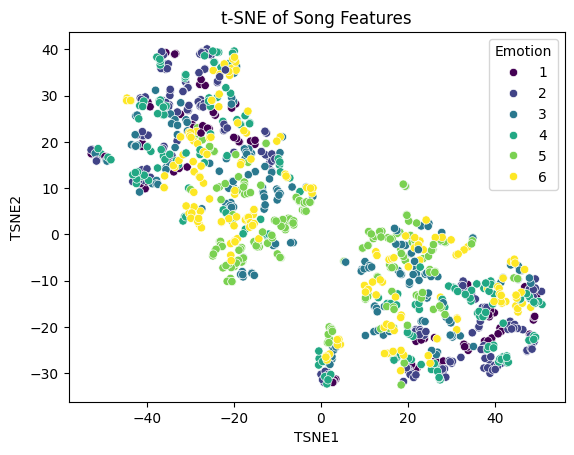

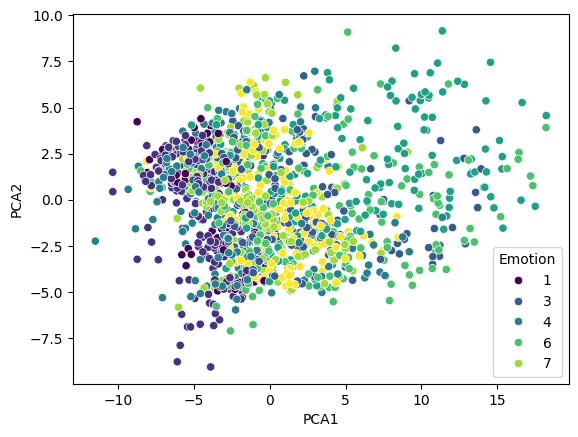

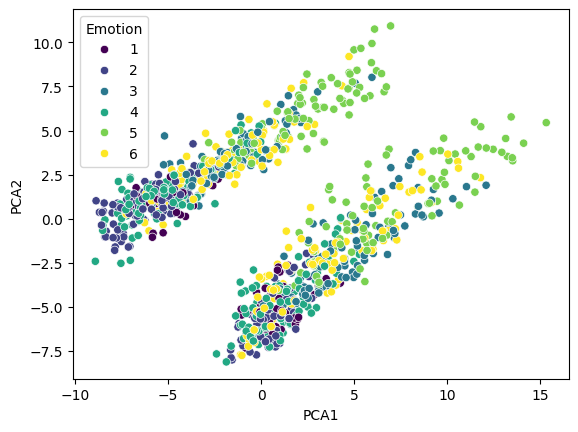

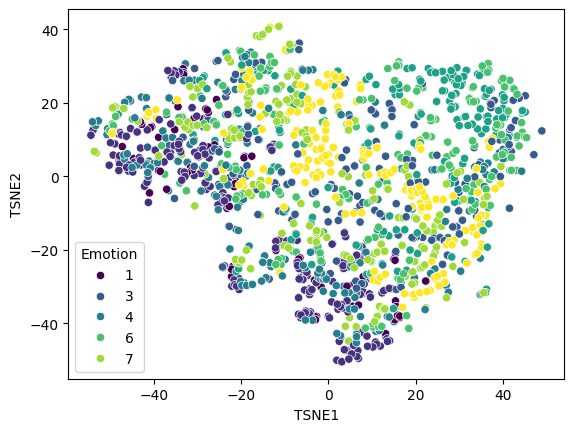

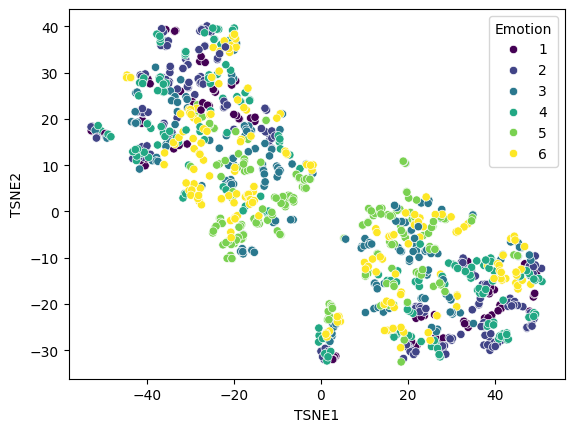

In [28]:
scaler_speech = StandardScaler()
x_speech_scaled = scaler_speech.fit_transform(x_speech)

scaler_song = StandardScaler()
x_song_scaled = scaler_song.fit_transform(x_song)

pca_speech = PCA(n_components=2)
pca_speech_result = pca_speech.fit_transform(x_speech_scaled)
pca_speech_df = pd.DataFrame(data=pca_speech_result, columns=['PCA1', 'PCA2'])
pca_speech_df['Label'] = y_speech

pca_song = PCA(n_components=2)
pca_song_result = pca_song.fit_transform(x_song_scaled)
pca_song_df = pd.DataFrame(data=pca_song_result, columns=['PCA1', 'PCA2'])
pca_song_df['Label'] = y_song

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=pca_speech_df, palette='viridis')
plt.title('PCA of Speech Features')
plt.legend(title='Emotion')
plt.show()

sns.scatterplot(x='PCA1', y='PCA2', hue='Label', data=pca_song_df, palette='viridis')
plt.title('PCA of Song Features')
plt.legend(title='Emotion')
plt.show()

tsne_speech = TSNE(n_components=2, random_state=42)
tsne_speech_result = tsne_speech.fit_transform(x_speech_scaled)
tsne_speech_df = pd.DataFrame(data=tsne_speech_result, columns=['TSNE1', 'TSNE2'])
tsne_speech_df['Label'] = y_speech

tsne_song = TSNE(n_components=2, random_state=42)
tsne_song_result = tsne_song.fit_transform(x_song_scaled)
tsne_song_df = pd.DataFrame(data=tsne_song_result, columns=['TSNE1', 'TSNE2'])
tsne_song_df['Label'] = y_song

sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_speech_df, palette='viridis')
plt.title('t-SNE of Speech Features')
plt.legend(title='Emotion')
plt.show()

sns.scatterplot(x='TSNE1', y='TSNE2', hue='Label', data=tsne_song_df, palette='viridis')
plt.title('t-SNE of Song Features')
plt.legend(title='Emotion')
plt.show()


## Filename identifiers 

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x_speech, y_speech)
print(x_train.shape)
print(y_train.shape)

x_train_norm = normalization(x_train, np.mean(x_train, axis=0), np.std(x_train, axis=0))
x_test_norm = normalization(x_test, np.mean(x_train, axis=0), np.std(x_train, axis=0))
print(x_train_norm.shape)
print(x_test_norm.shape)


(1092, 88)
(1092,)
(1092, 88)
(364, 88)


## Random Forest

In [9]:
num_trees = range(50, 200)
for n in num_trees:
    random_forest = RandomForestClassifier(n_estimators=n, random_state= 32)
    random_forest.fit(x_train, y_train)
    y_predict = random_forest.predict(x_test)
    acc = accuracy_score(y_test, y_predict)
    print(f"{n} trees --> Accuracy {acc}")




50 trees --> Accuracy 0.5521978021978022
51 trees --> Accuracy 0.5521978021978022
52 trees --> Accuracy 0.5576923076923077
53 trees --> Accuracy 0.5604395604395604
54 trees --> Accuracy 0.5631868131868132
55 trees --> Accuracy 0.5659340659340659
56 trees --> Accuracy 0.5714285714285714
57 trees --> Accuracy 0.5796703296703297
58 trees --> Accuracy 0.5769230769230769
59 trees --> Accuracy 0.5796703296703297
60 trees --> Accuracy 0.5769230769230769
61 trees --> Accuracy 0.5796703296703297
62 trees --> Accuracy 0.5796703296703297
63 trees --> Accuracy 0.5769230769230769
64 trees --> Accuracy 0.5769230769230769
65 trees --> Accuracy 0.5769230769230769
66 trees --> Accuracy 0.5796703296703297
67 trees --> Accuracy 0.5879120879120879
68 trees --> Accuracy 0.5906593406593407
69 trees --> Accuracy 0.5934065934065934
70 trees --> Accuracy 0.5879120879120879
71 trees --> Accuracy 0.5824175824175825
72 trees --> Accuracy 0.5879120879120879
73 trees --> Accuracy 0.5906593406593407
74 trees --> Acc

KeyboardInterrupt: 

In [ ]:
random_forest = RandomForestClassifier( random_state= 32)
random_forest.fit(x_train, y_train)
y_predict = random_forest.predict(x_test)
acc = accuracy_score(y_test, y_predict)
print(f" trees --> Accuracy {acc}")

conf_matrix = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(classification_report(y_test, y_predict))


 trees --> Accuracy 0.6456043956043956
Confusion Matrix:
[[10  7  1  1  0  0  0  0]
 [ 4 51  0  1  0  0  3  0]
 [ 1  3 31  1  2  6  1  3]
 [ 0 10 10 22  0  3  3  2]
 [ 1  0  4  1 28  1  7  4]
 [ 1  0  1  7  7 23  1  3]
 [ 2  5  4  1  2  1 31  5]
 [ 1  0  2  1  0  3  2 39]]

Classification Report:
              precision    recall  f1-score   support

           1       0.50      0.53      0.51        19
           2       0.67      0.86      0.76        59
           3       0.58      0.65      0.61        48
           4       0.63      0.44      0.52        50
           5       0.72      0.61      0.66        46
           6       0.62      0.53      0.57        43
           7       0.65      0.61      0.63        51
           8       0.70      0.81      0.75        48

    accuracy                           0.65       364
   macro avg       0.63      0.63      0.63       364
weighted avg       0.64      0.65      0.64       364



In [ ]:
class MLPAutoencoder(nn.Module):
    def __init__(self, encoding_dim):
        super(MLPAutoencoder, self).__init__()
        #self.flatten = nn.Flatten()
        self.encoder = nn.Linear(88, encoding_dim)
        self.decoder = nn.Linear(encoding_dim, 88)
        #self.unflatten = torch.nn.Unflatten(1, 88)

    def forward(self, x):
        #x = self.flatten(x)
        out = F.relu(self.encoder(x))
        out = torch.sigmoid(self.decoder(out))
        return out
    
    def get_embedding(self, x):
        #x = self.flatten(x)
        return F.relu(self.encoder(x))
d = torch.from_numpy(x_train)
print(d.shape)
print(nn.Flatten(d))
print(d[0].shape)

torch.Size([1092, 88])
Flatten(
  start_dim=tensor([[ 28.3506,   0.1082,  26.3177,  ...,   0.4340,   0.4470, -40.2734],
          [ 33.5943,   0.1317,  31.6795,  ...,   0.5000,   0.4614, -43.6438],
          [ 38.3756,   0.0760,  36.9474,  ...,   0.6533,   0.4067, -25.7631],
          ...,
          [ 42.9082,   0.0954,  39.0558,  ...,   0.4240,   0.4182, -35.3639],
          [ 34.5565,   0.1223,  31.9149,  ...,   0.4825,   0.4197, -41.9811],
          [ 37.9959,   0.1589,  36.0020,  ...,   0.5025,   0.4694, -35.2589]]), end_dim=-1
)
torch.Size([88])


In [ ]:
model = MLPAutoencoder(x_train.shape[1])
pred = model(d)


In [ ]:
LR = 0.1
device = "cpu"
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

n_epochs = 20
model.to(device)
t_losses, v_losses = [], []
x_train_tensor = torch.from_numpy(x_train_norm)
x_test_tensor = torch.from_numpy(x_test_norm)

for epoch in tqdm(range(1, n_epochs+1)):
    # Training
    train_loss = 0.0
    for (X, y) in zip(x_train_tensor, y_train):
        X = torch.squeeze(X).to(device)
        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, X)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
            
    # Eval        
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for (X, y) in zip(x_test_tensor, y_test):
            X = torch.squeeze(X).to(device)
            outputs = model(X)
            loss = criterion(outputs, X)
            test_loss += loss.item()        
            
    train_loss = train_loss/len(x_train)
    test_loss = test_loss/len(x_test)
    t_losses.append(train_loss)
    v_losses.append(test_loss)
    
plt.figure(figsize=(10,3))
plt.plot(np.arange(1,len(t_losses)+1), t_losses, label='Train loss')
plt.plot(np.arange(1,len(v_losses)+1),v_losses, label='Validation loss')
plt.xticks(np.arange(1,len(t_losses)+1))
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend()
plt.show()

 65%|██████▌   | 13/20 [00:31<00:18,  2.62s/it]